# Kinetic Energy

Mean and Eddy Kinetic Energy

## Theory

For a hydrostatic ocean like MOM5, the relevant kinetic energy per mass is 

$$ KE = \frac{1}{2} (u^2 + v^2).$$

The vertical velocity component, $w$, does not appear in the mechanical energy budget. It is very much subdominant. But more fundamentally, it simply does not appear in the mechanical energy buget for a hydrostatic ocean. 

For a non-steady fluid, we can define the time-averaged kinetic energy as the __total kinetic energy__, TKE

$$ TKE = \left< K \right > = \frac{1}{T} \int_0^T \frac{1}{2} \left( u^2 + v^2 \right) dt $$

It is useful to decompose the velocity in the mean and time varying components

$$ u = \bar{u} + u'$$

The __mean kinetic energy__ is the energy associated with the mean flow

$$ MKE = \frac{1}{2} \left( \bar{u}^2 + \bar{v}^2 \right) $$

The kinetic energy of the time varying component is the __eddy kinetic energy__, EKE. This quantity can be obtained by 
substracting the velocity means and calculating the kinetic energy of the 
perturbation velocity quantities.

$$ EKE = \left< \frac{1}{2} \left( \left(u - \left<u\right>\right)^2 + 
                                 \left(v - \left<v\right>\right)^2
                                 \right) \right> $$
                                 
MKE and EKE partition the total kinetic energy

$$TKE = EKE + MKE $$


## Calculation


We start by importing some useful packages.

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import cmocean as cm
import xarray as xr

from dask.distributed import Client

Start up a dask cluster.

In [2]:
client = Client(n_workers=6)
client

Client Scheduler: tcp://127.0.0.1:43549 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 6 Cores: 12 Memory: 34.36 GB


Create a database session and select an experiment. Here we choose an experiment which has daily velocities saved for the Southern Ocean.

In [3]:
session = cc.database.create_session()
expt = '01deg_jra55v13_ryf9091'

While not difficult to write down, this is fairly involved computation since to compute the eddy kinetic energy requires both the velocity and the mean of the velocity components.  Since the dataset is large, we want to avoid loading all of the velocity data into memory at the same time.

To calculate EKE, we need horizontal velocities $u$ and $v$, preferably saved at `1 daily` frequency (or perhaps `5 daily`). You can check whether your experiment has that kind of data:

In [4]:
varlist = cc.querying.get_variables(session, expt,frequency = '1 daily')
varlist

,name,frequency,ncfile,# ncfiles,time_start,time_end
0,average_DT,1 daily,output298/ocean/ocean_daily.nc,105,1950-01-01 00:00:00,1975-10-01 00:00:00
1,average_T1,1 daily,output298/ocean/ocean_daily.nc,105,1950-01-01 00:00:00,1975-10-01 00:00:00
2,average_T2,1 daily,output298/ocean/ocean_daily.nc,105,1950-01-01 00:00:00,1975-10-01 00:00:00
3,eta_t,1 daily,output298/ocean/ocean_daily.nc,103,1950-01-01 00:00:00,1975-10-01 00:00:00
4,frazil_3d_int_z,1 daily,output298/ocean/ocean_daily.nc,78,1956-04-01 00:00:00,1975-10-01 00:00:00
5,mld,1 daily,output298/ocean/ocean_daily.nc,103,1950-01-01 00:00:00,1975-10-01 00:00:00
6,nv,1 daily,output298/ocean/ocean_daily.nc,105,1950-01-01 00:00:00,1975-10-01 00:00:00
7,pme_river,1 daily,output298/ocean/ocean_daily.nc,78,1956-04-01 00:00:00,1975-10-01 00:00:00
8,salt,1 daily,output279/ocean/ocean_daily_3d_salt_12.nc,252,1950-01-01 00:00:00,1971-01-01 00:00:00
9,sfc_hflux_coupler,1 daily,output298/ocean/ocean_daily.nc,78,1956-04-01 00:00:00,1975-10-01 00:00:00


### Example

For example, let's calculate the mean and eddy kinetic energy over the last year of this particular model run:

In [5]:
start_time = '1970-01-01'

Here we build datasets for the variables u and v

In [6]:
u = cc.querying.getvar(expt,'u',session,ncfile='ocean_daily_3d_u_%.nc',start_time = start_time)
v = cc.querying.getvar(expt,'v',session,ncfile='ocean_daily_3d_v_%.nc',start_time = start_time)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.10/lib/python3.6/site-packages/cosima_cookbook/querying.py:134: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  **xr_kwargs
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.10/lib/python3.6/site-packages/xarray/backends/api.py:933: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,
/g/data3/hh5/public/apps/min

The kinetic energy is given by

$$ KE = \frac{1}{2} (u^2 + v^2)$$

we construct the following expression:

In [7]:
KE = 0.5*(u**2 + v**2)

You may notice that this line takes only a moment to run. The calculation is not (yet) being run. Rather, XArray needs to broadcast the squares of the velocity fields together to determine the final shape of KE. 

In [8]:
print(KE.shape)

(396, 75, 900, 3600)


This is too large to store locally.  We need to reduce the data in some way.  

The mean kinetic energy is calculated by this function

In [9]:
def calculate_MKE(KE):
    MKE = KE.mean('time').sum('st_ocean')
    return MKE

While we could try and compute this DataArray using the new mapblocks  function:

In [10]:
MKE = xr.map_blocks(calculate_MKE, KE)
MKE.data

dask.array<calculate_MKE-2e757c5a1222f345e8d85b5ccf01199f-<this, shape=(900, 3600), dtype=float32, chunksize=(300, 400), chunktype=numpy.ndarray>

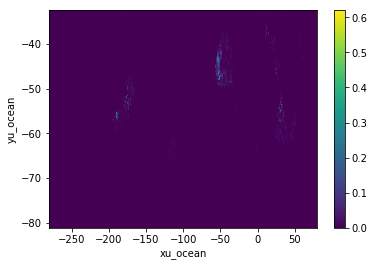

In [11]:
MKE.plot()

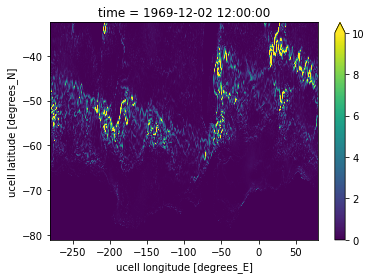

In [30]:
KE.isel(time=1).sum('st_ocean').plot(vmax=10)

## Mean Kinetic Energy

For the mean kinetic energy, we need to average the velocities over time over time.

In [22]:
u_mean = u.mean('time')
v_mean = v.mean('time')

In [23]:
MKE = 0.5*(u_mean**2 + v_mean**2)
MKE = MKE.sum('st_ocean')

In [24]:
MKE.plot(vmax=1)

distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


KeyboardInterrupt: 

## Eddy Kinetic Energy

We calculate the perturbation velocities

In [63]:
u_ = u - u_mean
v_ = v - v_mean

In [68]:
EKE = 0.5 * (u_**2 + v_**2)

In [69]:
EKE = EKE.mean('time').sum(['st_ocean'])

In [ ]:
EKE = cc.compute_by_block(EKE)

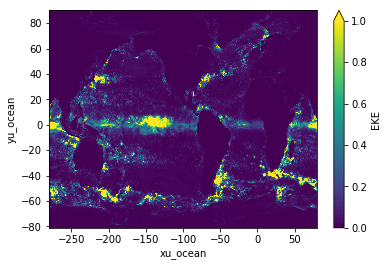

In [73]:
EKE.plot(vmax=1)
plt.show()

### Functions

In [3]:
from joblib import Memory

memory = Memory(cachedir='/g/data1/v45/cosima-cookbook/',verbose=0)

Here are functions for calculating both MKE and EKE.

In [31]:
@memory.cache
def calc_mke(expt, n=6):
    
    print('Opening datasets...')
    u = cc.get_nc_variable(expt, 'ocean__\d+_\d+.nc', 'u', 
                       time_units = 'days since 2000-01-01', 
                       n=n)
    v = cc.get_nc_variable(expt, 'ocean__\d+_\d+.nc', 'v', 
                       time_units = 'days since 2000-01-01', 
                       n=n)
    
    print('Preparing computation...')
    u_mean = u.mean('time')
    v_mean = v.mean('time')
    
    MKE = 0.5*(u_mean**2 + v_mean**2)
    MKE = MKE.sum('st_ocean')
    
    print('Calculating...')
    MKE = cc.compute_by_block(MKE)
    
    return MKE

In [ ]:
%%time
MKE = calc_mke('KDS75', n=6)

In [7]:
@memory.cache
def calc_eke(expt, n=6):
    
    print('Opening datasets...')
    u = cc.get_nc_variable(expt, 'ocean__\d+_\d+.nc', 'u', 
                       time_units = 'days since 2000-01-01', 
                       n=n)
    v = cc.get_nc_variable(expt, 'ocean__\d+_\d+.nc', 'v', 
                       time_units = 'days since 2000-01-01', 
                       n=n)
    
    print('Preparing computation...')
    u_mean = u.mean('time')
    v_mean = v.mean('time')
    
    u_ = u - u_mean
    v_ = v - v_mean
    
    EKE = 0.5 * (u_**2 + v_**2)
    EKE = EKE.mean('time')
    EKE = EKE.sum(['st_ocean'])
    
    print('Calculating...')
    EKE = cc.compute_by_block(EKE)
    
    return EKE

In [15]:
%%time
EKE = calc_eke('KDS75', n=6)

CPU times: user 974 ms, sys: 1.95 s, total: 2.92 s
Wall time: 2.56 s


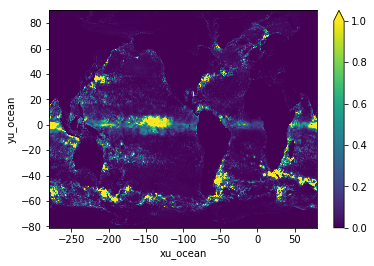

In [15]:
EKE.plot(vmax=1)
plt.show()

In [ ]:
%%time
EKE = calc_eke('KDS75', n=72)

In [ ]:
EKE.plot(vmax=1)
plt.show()

## Using dask directly

Note: Does not (yet) work but performance gains suggest that it may be further debugging for production use.

In [6]:
import netCDF4
import dask.array as da
import dataset

In [10]:
@memory.cache
def calc_mke_dask(expt, n=6):
    
    db = dataset.connect(cc.netcdf_index.database_url)

    res = db.query('SELECT ncfile'
         ' from ncfiles'
         ' where variable = "u"'
         ' AND experiment = "%s"'
         ' AND basename_pattern = "ocean__\d+_\d+.nc"'
         ' ORDER BY ncfile'
         ' LIMIT %d' % (expt, n),
        )
    rows = list(res)

    ncfiles = [row['ncfile'] for row in rows]

    u_dataarrays = [da.from_array(netCDF4.Dataset(ncfile, 'r')['u'],
            chunks=(1,7,300,400)) for ncfile in ncfiles]
    u = da.concatenate(u_dataarrays, axis=0)

    v_dataarrays = [da.from_array(netCDF4.Dataset(ncfile, 'r')['v'],
            chunks=(1,7,300,400)) for ncfile in ncfiles]
    v = da.concatenate(v_dataarrays, axis=0)

    u_mean = u.mean(axis=0)
    v_mean = v.mean(axis=0)

    MKE = 0.5*(u_mean**2 + v_mean**2)
    MKE = MKE.sum(axis=0)
     
    MKE = cc.compute_by_block(MKE)
    
    temp = cc.get_nc_variable(expt, 'ocean__\d+_\d+.nc', 'u', 
                       time_units = 'days since 2000-01-01', 
                       n=1)
    template = temp.mean('time').sum('st_ocean')
    result = xr.zeros_like(template).compute()
    result[:] = MKE
    result.name = 'MKE'
    
    return result

In [ ]:
%%time
MKE = calc_mke_dask('KDS75', n=6)

In [23]:
@memory.cache
def calc_eke_dask(expt, n=72):

    db = dataset.connect(cc.netcdf_index.database_url)

    res = db.query('SELECT ncfile'
         ' from ncfiles'
         ' where variable = "u"'
         ' AND experiment = "%s"'
         ' AND basename_pattern = "ocean__\d+_\d+.nc"'
         ' ORDER BY ncfile'
         ' LIMIT %d' % (expt, n)
        )
    ncfiles = [row['ncfile'] for row in res]

    u_dataarrays = [da.from_array(netCDF4.Dataset(ncfile, 'r')['u'],
            chunks=(1,7,300,400)) for ncfile in ncfiles]
    u = da.concatenate(u_dataarrays, axis=0)

    v_dataarrays = [da.from_array(netCDF4.Dataset(ncfile, 'r')['v'],
            chunks=(1,7,300,400)) for ncfile in ncfiles]
    v = da.concatenate(v_dataarrays, axis=0)

    u_mean = u.mean(axis=0)
    v_mean = v.mean(axis=0)

    u_ = u - u_mean
    v_ = v - v_mean

    EKE = 0.5 * (u_**2 + v_**2)
    EKE = EKE.mean(axis=0)
    EKE = EKE.sum(axis=0)
    
    EKE = cc.compute_by_block(EKE)
        
    temp = cc.get_nc_variable(expt, 'ocean__\d+_\d+.nc', 'u', 
                       time_units = 'days since 2000-01-01', 
                       n=1)
    template = temp.mean('time').sum('st_ocean')
    result = xr.zeros_like(template).compute()
    result[:] = EKE
    result.name = 'EKE'
    
    return result

In [ ]:
%%time
EKE = calc_eke_dask('KDS75', 2)

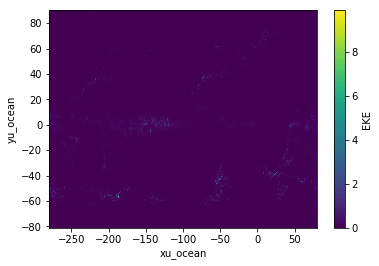

In [26]:
EKE.plot(vmax=1)
plt.show()

## Visualization

In [30]:
%matplotlib inline

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

Opening 6 ncfiles...
Building dataarray.
Dataarray constructed.
Opening 6 ncfiles...
Building dataarray.
Dataarray constructed.


HBox(children=(IntProgress(value=0, max=81), HTML(value='')))

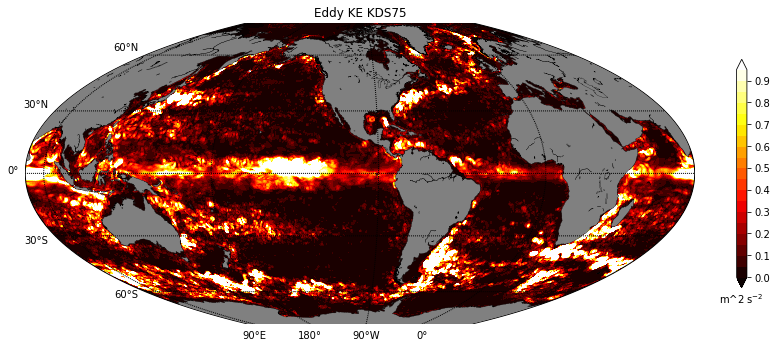

In [34]:
# Plot in basemap 

plt.figure(figsize=(15,6))
lev = np.arange(0, 1.0, 0.05)
map = Basemap(projection='mbtfpq',
              lon_0 = -100, resolution='l')
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
map.drawparallels(np.arange(-60.,61.,30.),
                  labels=[True,False,False,False])
map.drawmeridians(np.arange(-180.,181.,90.),
                  labels=[False,False,False,True])

expt = 'KDS75'
dsx = calc_eke(expt, n=6)
    
x=dsx.xu_ocean[:]
y=dsx.yu_ocean[:]
lon, lat = np.meshgrid(x, y)
    
X, Y = map(lon,lat) 

map.contourf(X, Y, dsx.data,
                 cmap=plt.cm.hot,
                 levels=lev,
                 extend='both')

cb = plt.colorbar(orientation='vertical',shrink = 0.7)

cb.ax.set_xlabel('m^2 s$^{-2}$')
plt.title('Eddy KE {}'.format(expt))